In [1]:
import numpy as np
from numpy import pi
import pandas as pd
import scipy.optimize as optimize
from scipy import interpolate
from scipy.optimize import fsolve, curve_fit
import scipy.fftpack as sfft

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, FixedFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from IPython.display import display, HTML, Video
import IPython

from numpy.polynomial.hermite import hermval
from math import factorial
from skimage import measure
import cv2
import finesse
from finesse.gaussian import HGMode, BeamParam
from finesse.cymath.zernike import Znm_eval
from finesse.knm.maps import map_scattering_coefficients, scattering_coefficients_to_KnmMatrix

from scipy.special import genlaguerre as LN
from scipy import interpolate, integrate

finesse.configure(plotting=True)

In [2]:
q_0 = 5j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
Theta = 1064e-9/np.pi/w0
print(Theta)
delta_x = w0*1
alpha = Theta*0.5

HG33_0 = HGMode(q_0, n=3, m=3)
x = y = np.linspace(-0.004, 0.004, 400)
HG33_0_data = HG33_0.unm(x, y)

x = np.linspace(-0.004, 0.004, 400)
y = np.linspace(-0.004, 0.004, 400)
HG33_0_data_offset = HG33_0.unm(x, y + delta_x)
HG33_0_data_tilt = HG33_0.unm(x, y)*np.exp(1j*2*np.pi/(1064e-9)*(alpha)*x)
# plt.imshow(np.abs(HG33_0_data_offset));

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

slice = 100
slice_33 = HG33_0_data[slice]/np.max(np.abs(HG33_0_data[slice]))
slice_33_offset = HG33_0_data_offset[slice]/np.max(np.abs(HG33_0_data_offset[slice]))
slice_33_tilt = HG33_0_data_tilt[slice]/np.max(np.abs(HG33_0_data_tilt[slice]))

0.00026026206750103
(3.574036407099139+0j)
-604.9972701160368
(7.881565146549124e-05+0j)
(3.574036407099139+0j)
-604.9972701160368
(7.881565146549124e-05+0j)
(3.574036407099139+0j)
-604.9972701160368
(7.881565146549124e-05+0j)


In [266]:
def draw_fill(color, segment=0):
    offset = 57
    center = 200
    idxs = [0, center-offset, center, center+offset, 400]
    idx1 = idxs[segment]
    idx2 = idxs[segment+1]
    if segment == 0:
        idx2 = idxs[segment+1] + 2
    if segment == 1:
        idx1 = idxs[segment] + 1
    if segment == 2:
        idx1 = idxs[segment] - 1
    ax.fill_between(x[idx1:idx2]/w0, np.abs(slice_33[idx1:idx2]), 0, color=color, alpha=0.5)
    ax.plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33[idx1:idx2]))/np.pi, 
            color=color, ls="--", alpha=1, lw=2.5)

    offset = 64
    if segment == 0:
        idx1 = 0
        idx2 = idxs[1] - offset
    elif segment == 3:
        idx1 = idxs[3] - offset
        idx2 = 400

    else:
        idx1 = idxs[segment] - offset
        idx2 = idxs[segment+1] - offset

    if segment == 0:
        idx2 += 1
    if segment == 1:
        idx2 -= 1
    if segment == 2:
        idx1 -= 2
    ax1.fill_between(x[idx1:idx2]/w0, np.abs(slice_33_offset[idx1:idx2]), 0, color=color, alpha=0.5)
    ax1.plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33_offset[idx1:idx2]))/np.pi, 
             color=color, ls="--", alpha=1, lw=2.5)

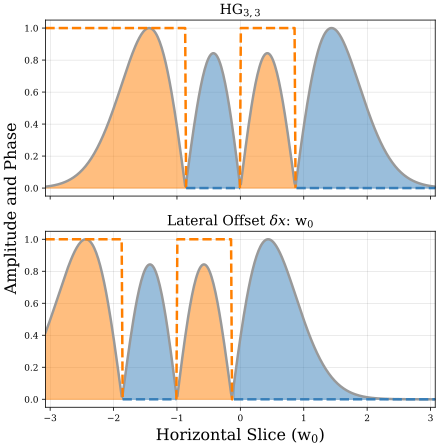

In [267]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7, 7))

ax.plot(x/w0, np.abs(slice_33), color=CB_color_cycle[6], alpha=1, lw=2.5)
ax1.plot(x/w0, np.abs(slice_33_offset), color=CB_color_cycle[6], alpha=1, lw=2.5)

draw_fill(segment=0, color=CB_color_cycle[1])
draw_fill(segment=1, color=CB_color_cycle[0])
draw_fill(segment=2, color=CB_color_cycle[1])
draw_fill(segment=3, color=CB_color_cycle[0])

ax1.set_xlabel(r"Horizontal Slice ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax1.set_ylabel("Amplitude and Phase", y=1.13, fontsize=16, labelpad=5)
ax.set_title(r"$\mathrm{HG}_{3, 3}$", fontsize=14)
ax1.set_title(r"Lateral Offset $\delta x$: $\mathrm{w}_{0}$", fontsize=14);

In [6]:
def calculate_opacity(x_value, segment=0):
    if segment==0:
        minn = min(abs(x_value)**0.5)
        maxx = max(abs(x_value)**0.5)
        x_value = ((maxx-abs(x_value)**0.5)/(maxx-minn))**3
        return x_value/2
    elif segment==1:
        minn = min(abs(x_value)**1)
        maxx = max(abs(x_value)**1)
        x_value = ((abs(x_value)**1-minn)/(maxx-minn))**2
        return x_value/2
    elif segment==2:
        minn = min(x_value**1)
        maxx = max(x_value**1)
        x_value = ((x_value**1 - minn)/(maxx-minn))**2
        return x_value/2
    else:
        minn = min(x_value**1)
        maxx = max(x_value**1)
        x_value = ((x_value**1-minn)/(maxx-minn))**1.5
        return x_value/2
        
def draw_fill_alpha(color, segment=0):
    offset = 57
    center = 200
    idxs = [0, center-offset, center, center+offset, 400]
    idx1 = idxs[segment]
    idx2 = idxs[segment+1]
    if segment == 0:
        idx2 = idxs[segment+1] + 2
    if segment == 1:
        idx1 = idxs[segment] + 1
    if segment == 2:
        idx1 = idxs[segment] - 1
    ax.fill_between(x[idx1:idx2]/w0, np.abs(slice_33[idx1:idx2]), 0, color=color, alpha=0.5)
    ax.plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33[idx1:idx2]))/np.pi, 
            color=color, ls="--", alpha=1, lw=2.5)

    y_segment_tilt = np.unwrap(np.angle(slice_33_tilt[idx1:idx2])+np.pi)/np.pi
    index = y_segment_tilt > 1.5
    y_segment_tilt[index] -= 2
    opacity_values = calculate_opacity(x[idx1:idx2]/w0, segment=segment)

    x_segment = x[idx1:idx2]/w0
    y_segment = np.abs(slice_33[idx1:idx2])
    ax1.plot(x_segment, y_segment_tilt, color=color, ls="--", lw=2.5, alpha=1)
    for i in range(len(x_segment) - 1):
        x_segment_fill = [x_segment[i], x_segment[i + 1]]
        y_segment_fill = [y_segment[i], y_segment[i + 1]]
        opacity = opacity_values[i]
    
        ax1.fill_between(x_segment_fill, y_segment_fill, 0, interpolate=True, color=color, 
                         linewidth=3, alpha=opacity)

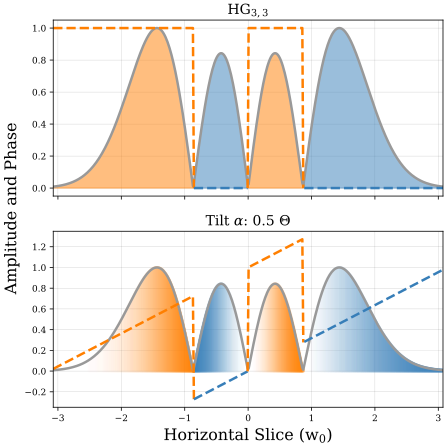

In [7]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7, 7))

ax.plot(x/w0, np.abs(slice_33), color=CB_color_cycle[6], alpha=1, lw=2.5)

ax1.plot(x/w0, np.abs(slice_33_tilt), ls="-", color=CB_color_cycle[6], lw=2.5)

draw_fill_alpha(segment=0, color=CB_color_cycle[1])
draw_fill_alpha(segment=1, color=CB_color_cycle[0])
draw_fill_alpha(segment=2, color=CB_color_cycle[1])
draw_fill_alpha(segment=3, color=CB_color_cycle[0])

ax1.set_xlabel("Horizontal Slice", fontsize=16, labelpad=5)
ax1.set_ylabel("Amplitude and Phase", y=1.13, fontsize=16, labelpad=5)
ax.set_title(r"$\mathrm{HG}_{3, 3}$", fontsize=16)
ax1.set_title(r"Waist Position Mismatch $\delta \mathrm{z}: 0.1 \, \mathrm{z_{R}} $", fontsize=16);

ax1.set_xlabel(r"Horizontal Slice ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax1.set_ylabel("Amplitude and Phase", y=1.13, fontsize=16, labelpad=5)
ax1.set_title(r"Tilt $\alpha$: 0.5 $\Theta$", fontsize=14)
ax.set_title(r"$\mathrm{HG}_{3, 3}$", fontsize=14);

In [8]:
slope = 2*np.pi/(1064e-9)*alpha
slope*w0/np.pi

0.3183098861837907

In [9]:
q_0 = 5j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

zR = np.imag(q_0)
zs = np.linspace(-1, 1, 100)*0.4*zR

q_z = q_0 + zR*0.1
HG33_0 = HGMode(q_0, n=3, m=3)
HG33_z = HGMode(q_z, n=3, m=3)

w_new = w0*(1+0.5)
zR_new = np.pi*w_new**2/(1064e-9)
q_w = q_0.real + 1j*zR_new
HG33_w = HGMode(q_w, n=3, m=3)

x = y = np.linspace(-0.004, 0.004, 400)

HG33_0_data = HG33_0.unm(x, y)
HG33_z_data = HG33_z.unm(x, y)
HG33_w_data = HG33_w.unm(x, y)


CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

slice = 100
slice_33 = HG33_0_data[slice]/np.max(np.abs(HG33_0_data[slice]))
slice_33_z = HG33_z_data[slice]/np.max(np.abs(HG33_z_data[slice]))
slice_33_w = HG33_w_data[slice]/np.max(np.abs(HG33_w_data[slice]))

(3.574036407099139+0j)
-604.9972701160368
(7.881565146549124e-05+0j)
(3.350426445890343+1.2185997073220802j)
-595.5205219798779
(5.1358007744007196e-05-6.965863959698699e-05j)
(2.918188506507661+0j)
-159.9382515885419
(0.01500625108260632+0j)


In [10]:
def draw_fill_z(color, segment=0):
    offset = 57
    center = 200
    idxs = [0, center-offset, center, center+offset, 400]
    idx1 = idxs[segment]
    idx2 = idxs[segment+1]
    if segment == 0:
        idx2 = idxs[segment+1] + 2
    if segment == 1:
        idx1 = idxs[segment] + 1
    if segment == 2:
        idx1 = idxs[segment] - 1
    ax.fill_between(x[idx1:idx2]/w0, np.abs(slice_33[idx1:idx2]), 0, color=color, alpha=0.5)
    ax.plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33[idx1:idx2]))/np.pi, 
            color=color, ls="--", alpha=1, lw=2.5)

    ax1.fill_between(x[idx1:idx2]/w0, np.abs(slice_33_z[idx1:idx2]), 0, color=color, alpha=0.5)
    angle = np.unwrap(np.pi-np.angle(slice_33_z[idx1:idx2]))/np.pi 
    # 1+np.angle(slice_33_z[idx1:idx2])/np.pi
    index = np.abs(angle-2) < 1e-3
    angle[index] = 0
    index = angle > 1.5
    angle[index] -= 2
    ax1.plot(x[idx1:idx2]/w0, angle, color=color, ls="--", alpha=1, lw=2.5)

In [13]:
z = 0.1*zR
Rcz = z + zR**2/z 
Gouy = 7*np.arctan(z/zR)/np.pi
print(Gouy)
coeff = 1/(1064e-9*Rcz)*w0**2
# print(coeff)
def curvature_fit(x):
    return coeff*x**2 - 0.15
# where x/w0 = 1, the phase drops by 0.315 pi

0.22207862201387502


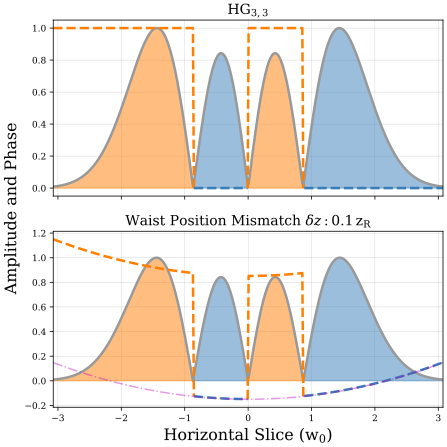

In [14]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7, 7))

ax.plot(x/w0, np.abs(slice_33), color=CB_color_cycle[6], alpha=1, lw=2.5)
ax1.plot(x/w0, np.abs(slice_33_z), color=CB_color_cycle[6], alpha=1, lw=2.5)

draw_fill_z(segment=0, color=CB_color_cycle[1])
draw_fill_z(segment=1, color=CB_color_cycle[0])
draw_fill_z(segment=2, color=CB_color_cycle[1])
draw_fill_z(segment=3, color=CB_color_cycle[0])

ax1.plot(x/w0, curvature_fit(x/w0), "m-.", lw=1.5, alpha=0.4)
ax1.set_xlabel(r"Horizontal Slice ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax1.set_ylabel("Amplitude and Phase", y=1.13, fontsize=16, labelpad=5)
ax.set_title(r"$\mathrm{HG}_{3, 3}$", fontsize=14)
ax1.set_title(r"Waist Position Mismatch $\delta z: 0.1 \, \mathrm{z_{R}} $", fontsize=14);

In [12]:
0.15/0.031725517430553574

4.728055273750744

In [379]:
(1-0.15)/0.031725517430553574

187.5461925254462

In [15]:
def draw_fill_w(color, segment=0):
    offset = 57
    center = 200
    idxs = [0, center-offset, center, center+offset, 400]
    idx1 = idxs[segment]
    idx2 = idxs[segment+1]
    if segment == 0:
        idx2 = idxs[segment+1] + 2
    if segment == 1:
        idx1 = idxs[segment] + 1
    if segment == 2:
        idx1 = idxs[segment] - 1
    ax.fill_between(x[idx1:idx2]/w0, np.abs(slice_33[idx1:idx2]), 0, color=color, alpha=0.5)
    ax.plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33[idx1:idx2]))/np.pi, 
            color=color, ls="--", alpha=1, lw=2.5)

    offset = 85
    center = 200
    idxs = [0, center-offset, center, center+offset, 400]
    idx1 = idxs[segment]
    idx2 = idxs[segment+1]
    if segment == 0:
        idx2 = idxs[segment+1] + 2
    if segment == 1:
        idx1 = idxs[segment] + 1
    if segment == 2:
        idx1 = idxs[segment] - 1
    ax1.fill_between(x[idx1:idx2]/w0, np.abs(slice_33_w[idx1:idx2]), 0, color=color, alpha=0.5)
    ax1.plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33_w[idx1:idx2]))/np.pi, 
            color=color, ls="--", alpha=1, lw=2.5)

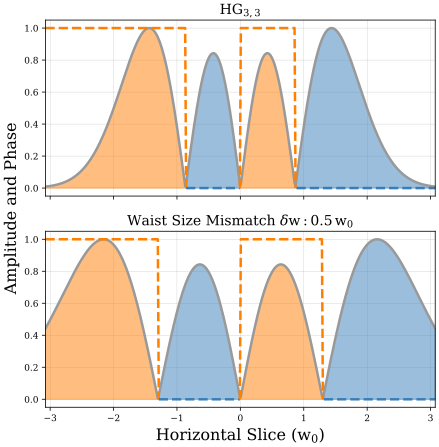

In [16]:
fig, (ax, ax1) = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(7, 7))

ax.plot(x/w0, np.abs(slice_33), color=CB_color_cycle[6], alpha=1, lw=2.5)
ax1.plot(x/w0, np.abs(slice_33_w), color=CB_color_cycle[6], alpha=1, lw=2.5)

draw_fill_w(segment=0, color=CB_color_cycle[1])
draw_fill_w(segment=1, color=CB_color_cycle[0])
draw_fill_w(segment=2, color=CB_color_cycle[1])
draw_fill_w(segment=3, color=CB_color_cycle[0])

ax1.set_xlabel(r"Horizontal Slice ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax1.set_ylabel("Amplitude and Phase", y=1.13, fontsize=16, labelpad=5)
ax.set_title(r"$\mathrm{HG}_{3, 3}$", fontsize=14)
ax1.set_title(r"Waist Size Mismatch $\delta \mathrm{w}: 0.5 \, \mathrm{w_{0}} $", fontsize=14);

In [17]:
85/57

1.4912280701754386

In [276]:
q_0 = 4j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
delta_x = w0*0.1

HG33_0 = HGMode(q_0, n=3, m=3)
HG43_0 = HGMode(q_0, n=4, m=3)
HG23_0 = HGMode(q_0, n=2, m=3)
x = np.linspace(-0.004, 0.004, 400)
y = np.linspace(-0.004, 0.004, 400)
HG33_0_data = HG33_0.unm(x, y)
HG43_0_data = HG43_0.unm(x, y)
HG23_0_data = HG23_0.unm(x, y)

HG33_0_data_offset = HG33_0.unm(x - delta_x, y)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

slice = 100
slice_33_0 = np.real(HG33_0_data[:, slice])
slice_33_offset = np.real(HG33_0_data_offset[:, slice])
slice_43_0 = np.real(HG43_0_data[:, slice])
slice_23_0 = np.real(HG23_0_data[:, slice])

(3.779083391356991+0j)
-860.0898201517888
(7.426181972671784e-06+0j)
(1.3361077463489919+0j)
7805.41641228518
(7.426181972671784e-06+0j)
(9.256826004251215+0j)
92.48398958164793
(7.426181972671784e-06+0j)
(3.779083391356991+0j)
-940.9205839961895
(3.6975991764412444e-06+0j)


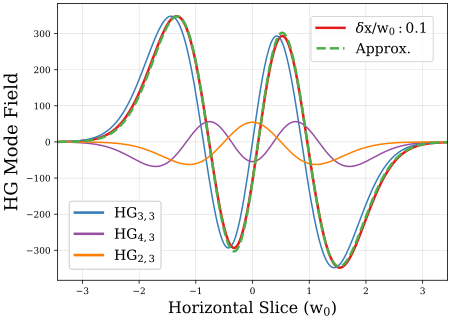

In [277]:
fig, ax = plt.subplots(figsize=(7, 5))

slice_33_offset_linear = slice_33_0*(1-(2*3+1)/2*(delta_x/w0)**2) + delta_x/w0*(np.sqrt(4)*slice_43_0-np.sqrt(3)*slice_23_0)
ax.plot(x/w0, slice_33_offset, label=r"$\delta \mathrm{x/w}_{0}: 0.1$", lw=2.5, color=CB_color_cycle[7])

ax.plot(x/w0, slice_33_0, label=r"$\mathrm{HG}_{3,3}$", lw=1.5, color=CB_color_cycle[0])
ax.plot(x/w0, slice_43_0*delta_x/w0*np.sqrt(4), label=r"$\mathrm{HG}_{4,3}$", lw=1.5, color=CB_color_cycle[5])
ax.plot(x/w0, slice_23_0*delta_x/w0*np.sqrt(3), label=r"$\mathrm{HG}_{2,3}$", lw=1.5, color=CB_color_cycle[1])

ax.plot(x/w0, slice_33_offset_linear, "--", label=r"Approx.", lw=2.5, color=CB_color_cycle[2])
ax.set_xlabel(r"Horizontal Slice ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax.set_ylabel("HG Mode Field", fontsize=18, labelpad=5)

handles, labels = ax.get_legend_handles_labels()
legend = plt.legend([handles[0], handles[4]], [labels[0], labels[4]], fontsize=14, ncols=1, loc=(0.65, 0.79));
ax.add_artist(legend)

legend = plt.legend(handles[1:4], labels[1:4], fontsize=14, ncols=1, loc=(0.03, 0.04));
ax.add_artist(legend)

legend_lines = legend.get_lines()
for idx, line in enumerate(legend_lines):
    line.set_linewidth(2.5)

In [285]:
q_0 = 4j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

w_new = w0*(1+0.06)
zR_new = np.pi*w_new**2/(1064e-9)
q_w = q_0.real + 1j*zR_new
HG33_w = HGMode(q_w, n=3, m=3)

HG33_0 = HGMode(q_0, n=3, m=3)
HG53_0 = HGMode(q_0, n=5, m=3)
HG13_0 = HGMode(q_0, n=1, m=3)
HG35_0 = HGMode(q_0, n=3, m=5)
HG31_0 = HGMode(q_0, n=3, m=1)

x = np.linspace(-0.004, 0.004, 400)
y = np.linspace(-0.004, 0.004, 400)

HG33_0_data = HG33_0.unm(x, y)
HG53_0_data = HG53_0.unm(x, y)
HG13_0_data = HG13_0.unm(x, y)
HG31_0_data = HG31_0.unm(x, y)
HG35_0_data = HG35_0.unm(x, y)

HG33_w_data = HG33_w.unm(x, y)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

slice = 100
slice_33_0 = np.real(HG33_0_data[slice])
slice_33_w = np.real(HG33_w_data[slice])
slice_13_0 = np.real(HG13_0_data[slice])
slice_53_0 = np.real(HG53_0_data[slice])
slice_31_0 = np.real(HG31_0_data[slice])
slice_35_0 = np.real(HG35_0_data[slice])

(3.779083391356991+0j)
-860.0898201517888
(7.426181972671784e-06+0j)
(0.4225143677857336+0j)
-68990.17322376199
(7.426181972671784e-06+0j)
(18.51365200850243+0j)
-9.720287525667539
(7.426181972671784e-06+0j)
(3.779083391356991+0j)
-860.0898201517888
(7.426181972671784e-06+0j)
(3.779083391356991+0j)
-860.0898201517888
(7.426181972671784e-06+0j)
(3.670570270694189+0j)
-716.0955477699322
(2.722699004038294e-05+0j)


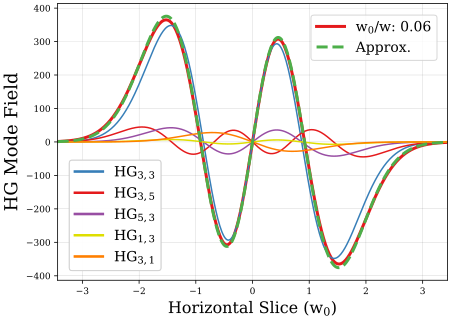

In [291]:
fig, ax = plt.subplots(figsize=(7, 5))

epsilon = w_new/w0 - 1
slice_33_w_linear = slice_33_0*(1-epsilon**2*13/4) + \
epsilon/2*(np.sqrt(4*5)*(slice_53_0+slice_35_0)-np.sqrt(3*2)*(slice_13_0+slice_31_0))
ax.plot(x/w0, slice_33_w, label=r"$\mathrm{w}_{0}$/w: 0.06", lw=3, color=CB_color_cycle[7])

ax.plot(x/w0, slice_33_0, label=r"$\mathrm{HG}_{3,3}$", lw=1.5, color=CB_color_cycle[0])
ax.plot(x/w0, slice_35_0*epsilon/2*np.sqrt(4*5), label=r"$\mathrm{HG}_{3,5}$", lw=1.5, color=CB_color_cycle[7])
ax.plot(x/w0, slice_53_0*epsilon/2*np.sqrt(4*5), label=r"$\mathrm{HG}_{5,3}$", lw=1.5, color=CB_color_cycle[5])
ax.plot(x/w0, slice_13_0*epsilon/2*np.sqrt(3*2), label=r"$\mathrm{HG}_{1,3}$", lw=1.5, color=CB_color_cycle[8])
ax.plot(x/w0, slice_31_0*epsilon/2*np.sqrt(3*2), label=r"$\mathrm{HG}_{3,1}$", lw=1.5, color=CB_color_cycle[1])

ax.plot(x/w0, slice_33_w_linear, "--", label=r"Approx.", lw=3, color=CB_color_cycle[2])
ax.set_xlabel(r"Horizontal Slice ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax.set_ylabel("HG Mode Field", fontsize=18, labelpad=5)
# legends = plt.legend(fontsize=12, ncols=1, loc=(0.63, 0.62))

handles, labels = ax.get_legend_handles_labels()
legend = plt.legend([handles[0], handles[6]], [labels[0], labels[6]], fontsize=14, ncols=1, loc=(0.65, 0.795));
ax.add_artist(legend)

legend = plt.legend(handles[1:6], labels[1:6], fontsize=14, ncols=1, loc=(0.03, 0.035));
ax.add_artist(legend)

legend_lines = legend.get_lines()
for idx, line in enumerate(legend_lines):
    line.set_linewidth(2.5)

In [1]:
q_0 = 3j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

HG_nm_datas = []
x = y = np.linspace(-0.004, 0.004, 400)
for n in range(4):
    temp = []
    for m in range(4):
        HG_nm = HGMode(q_0, n=n, m=m)
        HG_nm_data = np.real(HG_nm.unm(x, y))
        temp.append(HG_nm_data)
    HG_nm_datas.append(temp)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

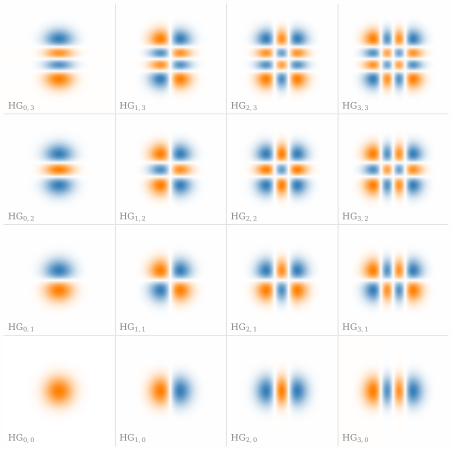

In [6]:
cmap_colors = [(0.0, CB_color_cycle[1]), (0.5, 'white'), (1.0, CB_color_cycle[0])]
custom_cmap = LinearSegmentedColormap.from_list("BlueWhiteRed", cmap_colors)
cmap_colors = [(0, 'white'), (1.0, CB_color_cycle[1])]
custom_cmap_00 = LinearSegmentedColormap.from_list("WhiteRed", cmap_colors)
background_color = custom_cmap(0.5)
# background_color = "lightgray"

fig, ax = plt.subplots(4, 4, figsize=(8,8))
plt.subplots_adjust(hspace=0, wspace=0) 

fig.patch.set_facecolor(background_color)

for n in range(4):
    for m in range(4):
        vmin = HG_nm_datas[3-n][m].min()
        vmax = HG_nm_datas[3-n][m].max()
        if n==3 and m==0:
            ax[n][m].imshow(HG_nm_datas[3-n][m], cmap=custom_cmap_00, vmin=vmin, vmax=vmax)
        else:
            vmin = HG_nm_datas[3-n][m].min()
            vmax = HG_nm_datas[3-n][m].max()
            ratio = 1/(-vmax/vmin+1)
            cmap_colors = [(0.0, CB_color_cycle[1]), (ratio, 'white'), (1.0, CB_color_cycle[0])]
            # cmap_colors = [(0.0, "b"), (ratio, 'white'), (1.0, "r")]
            custom_cmap = LinearSegmentedColormap.from_list("BlueWhiteRed", cmap_colors)
            ax[n][m].imshow(HG_nm_datas[3-n][m], cmap=custom_cmap, vmin=vmin, vmax=vmax)

        text = rf"$\mathrm{{HG}}_{{{m},{3-n}}}$"  # Text to be added
        ax[n][m].text(0.04, 0.03, text, transform=ax[n][m].transAxes, fontsize=9,
                verticalalignment='bottom', horizontalalignment='left',
                color='#808080', )#bbox={'facecolor': 'white', 'edgecolor': 'white', 'alpha': 1})

        ax[n][m].axis("off")
        if m>0:
            ax[n][m].axvline(x=0, color='lightgray', linestyle='-', linewidth=1)
        if n<3:
            ax[n][m].axhline(y=0, color='lightgray', linestyle='-', linewidth=1)

# fig.savefig('./HOMList.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

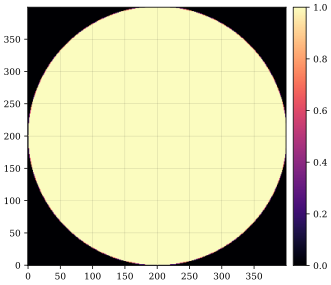

In [357]:
def HG_mirror_func(shapex=400, shapey=400, plot=False):
    HG_mirror = np.zeros((int(shapex), int(shapey)))
    center = [shapex / 2, shapey / 2]
    r = center[0]
    x = np.arange(shapex)
    y = np.arange(shapey)
    xv, yv = np.meshgrid(x, y)

    index = ((xv - center[0]))**2 + ((yv - center[1]))**2 <= r**2
    HG_mirror[index] = 1.

    if plot:
        plt.figure(figsize=(5, 5))
        ax = plt.gca()
        im = ax.imshow(HG_mirror)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        plt.colorbar(im, cax=cax)

    return HG_mirror


HG_mirror = HG_mirror_func(plot=True)

In [358]:
x = y = np.linspace(-0.004, 0.004, 400)
step = x[1]-x[0]

def clippingloss1ppm(n, m, wmin=1.5, wmax=1.6):
    clippingloss = []
    for w in w0*np.linspace(wmin, wmax, 100):
        q = 1j*np.pi*w**2/(1064e-9)
        HG_nm = HGMode(q, n=n, m=m)
        HG_nm_data = np.real(HG_nm.unm(x, y))*HG_mirror
        clippingloss.append((1-np.sum(HG_nm_data*HG_nm_data*step**2))*1e6)
    clippingloss = np.array(clippingloss)
    idx = np.argmin(np.abs(clippingloss - 1))
    radius = w0*np.linspace(wmin, wmax, 100)[idx]/0.004
    return clippingloss, radius

0.3461704627498133

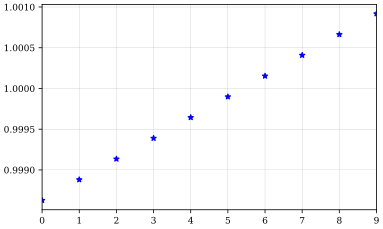

In [69]:
plt.plot(HG00_loss, "*")
r_00

In [66]:
R = 0.004
def HGnm_clipping(x, y, n=0, m=0, q=q_0):
    return np.abs(HGMode(q=q, n=n, m=m).unm(x, y))**2

def solve_beamsize(w, n=0, m=0):
    q = 1j*np.pi*w**2/(1064e-9)
    result, error = integrate.dblquad(HGnm_clipping, -R, R, lambda x:-(R**2-x**2)**0.5, 
                                  lambda x:(R**2-x**2)**0.5, args=(n, m, q[0]),)
            
    clippingloss = (1-result)*1e6
    # print(result)
    # print(clippingloss)
    return 1-clippingloss
    
    
result, error = integrate.dblquad(HGnm_clipping, -R, R, lambda x:-(R**2-x**2)**0.5, 
                                  lambda x:(R**2-x**2)**0.5, args=(0, 0, q_0),)
result, error

(0.9999999999999788, 1.4190391495345955e-08)

In [67]:
root = fsolve(solve_beamsize, x0=1.5098*w0, args=(0,0))
root[0]/w0

1.5098606494851239

In [74]:
def clippingloss1ppm(n, m, w_guess=1.5):
    root = fsolve(solve_beamsize, x0=w_guess*w0, args=(n,m))
    
    return root[0]/R

In [77]:
r_00 = clippingloss1ppm(0,0, 1.5098)
1/r_00

2.628249677560779

In [78]:
rs_HOMs = np.empty((7,7))
guess_dict = {"00":1.5098, "01":1.3737, "02":1.27, "11":1.283, "12":1.205, "03":1.19, "04":1.125,
             "13":1.14, "22":1.143, "50":1.072, "14":1.083, "23":1.0903, "06":1.0273, "15":1.0388,
             "24":1.0433, "33":1.0444, "16":0.9975, "25":1.0022, "34":1.004, "26":0.9653, "35":0.968,
             "44":0.9685, "36":0.9358, "45":0.9365, "46":0.9078, "55":0.908, "56":0.882, "66":0.8583,}
for n in range(7):
    for m in range(7):
        if n >= m:
            if f"{n}{m}" in guess_dict:
                w_guess = guess_dict[f"{n}{m}"]
            elif f"{m}{n}" in guess_dict:
                w_guess = guess_dict[f"{m}{n}"]
            else:
                print("Guess doesn't exist")
                
            root = clippingloss1ppm(n,m, w_guess)
            rs_HOMs[n,m] = root
            print(root, end=" ")

for n in range(7):
    for m in range(7):
        if n < m: 
            rs_HOMs[n, m] = rs_HOMs[m, n] 
rs_HOMs = np.array(rs_HOMs)

0.380481355533953 0.3461843068846075 0.32334559881425473 0.32020465973844175 0.3034698024623897 0.28780475906615605 0.3000083354422875 0.2869494719494613 0.2741679926010984 0.26267164114531233 0.2836709535622487 0.2730597738030816 0.26235287196582474 0.25248221669405296 0.24357567372349292 0.27004905613402785 0.2611784112344203 0.2520271517163594 0.24342553589116636 0.2355501905759121 0.22837282686929092 0.25843067370710116 0.25085629026612666 0.2429096420087834 0.2353220523362039 0.22829026912361852 0.2218198142212073 0.21586523452623052 

In [80]:
# np.save('./Save/rs_HOMs.npy', rs_HOMs)
rs_HOMs = np.load('./Save/rs_HOMs.npy')

In [390]:
# 00: 0.3804673447208943, 1.5098, 1.5099

# 10: 0.3461704627498133, 1.3737, 1.3738

# 20: 0.32091520602825, 1.27, 1.275
# 11: 0.3241020855677889, 1.283, 1.288

# 30: 0.3006663028836557, 1.19, 1.195
# 21: 0.30417899758378647, 1.205, 1.21

# 40: 0.28427372761637887, 1.125, 1.13
# 31: 0.28762096930527153, 1.14, 1.145
# 22: 0.28846605237805667, 1.143, 1.148

# 50: 0.2706123997500008, 1.072, 1.077
# 41: 0.27370255291373896, 1.083, 1.088
# 32: 0.2747950518740985, 1.0903, 1.0908

# 60: 0.2589637441295599, 1.0273, 1.0278
# 51: 0.26179960874217995, 1.0388, 1.039
# 42: 0.262957525277752, 1.0433, 1.0438
# 33: 0.2632617042753358, 1.0444, 1.0448

######## 70: 0.2488494742810312, 0.9873, 0.9878
# 61: 0.25145294104863536, 0.9975, 0.998
# 52: 0.2526144211875264, 1.0022, 1.0027
# 43: 0.2530484171631585, 1.004, 1.0043

######## 80: 0.23994886590570716, 0.952, 0.9525
######## 71: 0.24234538913771667, 0.9615, 0.962
# 62: 0.24347861499315013, 0.9653, 0.9668
# 53: 0.2439757376561469, 0.968, 0.9685
# 44: 0.24411191821155054, 0.9685, 0.969

######## 90: 0.23202493938287597, 0.9205, 0.921
######## 81: 0.23423997338871208, 0.9293, 0.9298
######## 72: 0.23533527232310789, 0.9335, 0.934
# 63: 0.23586141289884485, 0.9358, 0.9363
# 54: 0.23606708371896848, 0.9365, 0.937

# 64: 0.22879656931898043, 0.9078, 0.908
# 55: 0.22886478686822936, 0.908, 0.9085

# 65: 0.22229706595136167, 0.882, 0.8823

# 66: 0.21632141227163199, 0.8583, 0.8588

In [81]:
# rs_HOMs = np.array([
#     [0.38134373659426746, 0.34696769172088643, 0.32091520602825, 0.3006663028836557, 0.28427372761637887, 
#  0.2706123997500008, 0.2589637441295599
#  ], [0.34696769172088643, 0.3241020855677889, 0.30417899758378647, 0.28762096930527153, 0.27370255291373896, 
#      0.26179960874217995, 0.25145294104863536  
#  ], [0.32091520602825, 0.30417899758378647, 0.28846605237805667, 0.2747950518740985, 0.262957525277752, 
#      0.2526144211875264, 0.24347861499315013
#  ], [0.3006663028836557, 0.28762096930527153, 0.2747950518740985, 0.2632617042753358, 0.2530484171631585, 
#      0.2439757376561469, 0.23586141289884485
#  ], [0.28427372761637887, 0.27370255291373896, 0.262957525277752, 0.2530484171631585, 0.24411191821155054, 
#      0.23606708371896848, 0.22879656931898043
#  ], [0.2706123997500008, 0.26179960874217995, 0.2526144211875264, 0.2439757376561469, 0.23606708371896848, 
#      0.22886478686822936, 0.22229706595136167
#  ], [0.2589637441295599, 0.25145294104863536, 0.24347861499315013, 0.23586141289884485, 0.22879656931898043,
#      0.22229706595136167, 0.21632141227163199
#  ]
# ])
# print(np.array_equal(rs_HOMs, rs_HOMs.T))
# rs_HOMs = rs_HOMs.round(decimals=3)

In [83]:
print(np.array_equal(rs_HOMs, rs_HOMs.T))
(rs_HOMs).round(decimals=3)

True


array([[0.38 , 0.346, 0.32 , 0.3  , 0.284, 0.27 , 0.258],
       [0.346, 0.323, 0.303, 0.287, 0.273, 0.261, 0.251],
       [0.32 , 0.303, 0.288, 0.274, 0.262, 0.252, 0.243],
       [0.3  , 0.287, 0.274, 0.263, 0.252, 0.243, 0.235],
       [0.284, 0.273, 0.262, 0.252, 0.244, 0.236, 0.228],
       [0.27 , 0.261, 0.252, 0.243, 0.236, 0.228, 0.222],
       [0.258, 0.251, 0.243, 0.235, 0.228, 0.222, 0.216]])

array([0.381, 0.324, 0.288, 0.263, 0.244, 0.229, 0.216])

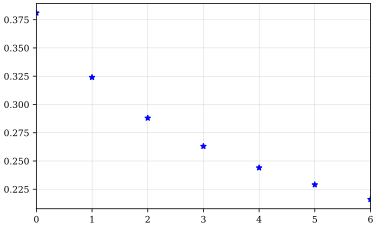

In [506]:
plt.plot(np.diagonal(rs_HOMs), "*");
np.diagonal(rs_HOMs)

In [49]:
q_0 = 5j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

HG33_0 = HGMode(q_0, n=3, m=3)
x = np.linspace(-0.004, 0.004, 400)
y = np.linspace(-0.004, 0.004, 400)
HG33_data = -np.real(HG33_0.unm(x, y))

HG33_slice = HG33_data[230]

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

(3.574036407099139+0j)
-604.9972701160368
(7.881565146549124e-05+0j)


In [50]:
def draw_fill_field(color, segment=0):
    offset = 57
    center = 200
    idxs = [0, center-offset, center, center+offset, 400]
    idx1 = idxs[segment]
    idx2 = idxs[segment+1]
    if segment == 0:
        idx2 = idxs[segment+1] + 2
    if segment == 1:
        idx1 = idxs[segment] + 1
    if segment == 2:
        idx1 = idxs[segment] - 1
    ax[0].fill_between(x[idx1:idx2]/w0, np.abs(HG33_slice[idx1:idx2]), 0, color=color, alpha=0.5)
    # ax[0].plot(x[idx1:idx2]/w0, np.unwrap(np.pi-np.angle(slice_33[idx1:idx2]))/np.pi, 
    #         color=color, ls="--", alpha=1, lw=2.5)

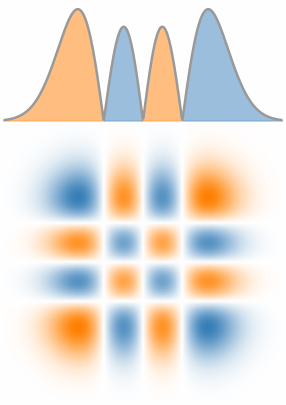

In [62]:
# HG33_data = np.real(HG_nm_datas[3][3])
# HG33_slice = HG33_data[100]/np.max(HG33_data[100])
fig, ax = plt.subplots(2, 1, figsize=(5,8), gridspec_kw={'height_ratios': [1,3]})
plt.subplots_adjust(hspace=-0.2) 

background_color = "lightgray"

cmap_colors = [(0.0, CB_color_cycle[1]), (0.5, 'white'), (1.0, CB_color_cycle[0])]
custom_cmap = LinearSegmentedColormap.from_list("BlueWhiteRed", cmap_colors)
background_color = custom_cmap(0.5)

fig.patch.set_facecolor(background_color)

ax[0].plot(x/w0, np.abs(HG33_slice), color=CB_color_cycle[6], alpha=1, lw=2.5)

draw_fill_field(segment=0, color=CB_color_cycle[1])
draw_fill_field(segment=1, color=CB_color_cycle[0])
draw_fill_field(segment=2, color=CB_color_cycle[1])
draw_fill_field(segment=3, color=CB_color_cycle[0])

# ax[0].set_ylabel("Amplitude and Phase", fontsize=16, labelpad=5)
# ax[1].axhline(y=230, xmin=0.0, xmax=0.1, color=CB_color_cycle[5], linestyle='-', linewidth=2.5)

ax[1].imshow(HG33_data, cmap=custom_cmap)
ax[0].xaxis.set_visible(False)
ax[0].axis("off")
ax[1].axis("off");

# fig.savefig('/Users/liutao/Desktop/Thesis/Segmented mirror/HG33_intensitynull.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);


In [2]:
q_0 = 2j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

# HG_nn_datas = []
g1nm_HOMs = []
x = y = np.linspace(-0.004, 0.004, 500)
for n in range(7):
    temp = []
    for m in range(7):
        HG_nn = HGMode(q_0, n=n, m=m)
        HG_nn_data = np.real(HG_nn.unm(x, y))
        temp.append(np.sum(HG_nn_data**4))
    g1nm_HOMs.append(temp)

g1nm_HOMs = np.array(g1nm_HOMs)

In [93]:
g1nm_HOMs = g1nm_HOMs/g1nm_HOMs[0,0]
# g1nm_HOMs = g1nm_HOMs.round(decimals=3)
g1nm_HOMs

array([[1.        , 0.75      , 0.640625  , 0.57421875, 0.52789307,
        0.4929657 , 0.46528721],
       [0.75      , 0.5625    , 0.48046875, 0.43066406, 0.3959198 ,
        0.36972427, 0.34896541],
       [0.640625  , 0.48046875, 0.41040039, 0.36785889, 0.3381815 ,
        0.31580615, 0.29807462],
       [0.57421875, 0.43066406, 0.36785889, 0.32972717, 0.3031261 ,
        0.28307015, 0.26717664],
       [0.52789307, 0.3959198 , 0.3381815 , 0.3031261 , 0.27867109,
        0.26023317, 0.24562189],
       [0.4929657 , 0.36972427, 0.31580615, 0.28307015, 0.26023317,
        0.24301518, 0.22937063],
       [0.46528721, 0.34896541, 0.29807462, 0.26717664, 0.24562189,
        0.22937063, 0.21649219]])

In [94]:
g1nm_norm_HOMs = rs_HOMs**2/g1nm_HOMs
g1nm_norm_HOMs = g1nm_norm_HOMs/g1nm_norm_HOMs[0,0]
g1nm_norm_HOMs = g1nm_norm_HOMs.round(decimals=3)
g1nm_norm_HOMs

array([[1.   , 1.104, 1.106, 1.083, 1.053, 1.022, 0.992],
       [1.104, 1.284, 1.324, 1.321, 1.301, 1.274, 1.246],
       [1.106, 1.324, 1.394, 1.412, 1.406, 1.389, 1.367],
       [1.083, 1.321, 1.412, 1.445, 1.453, 1.446, 1.432],
       [1.053, 1.301, 1.406, 1.453, 1.471, 1.473, 1.466],
       [1.022, 1.274, 1.389, 1.446, 1.473, 1.482, 1.482],
       [0.992, 1.246, 1.367, 1.432, 1.466, 1.482, 1.487]])

In [4]:
def func(n, a, b):
    return a * n + b

[0.46789895 1.60388605]


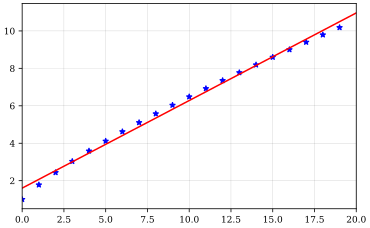

In [5]:
popt, pcov = curve_fit(func, np.arange(20), CTN_HOM)
print(popt)
plt.plot(CTN_HOM, "*")
xdata = np.linspace(0, 20, 100)
plt.plot(xdata, func(xdata, *popt), 'r-');

In [517]:
def g0nm(phi, t, n=0, m=0):
    return LN(n=n, alpha=0)(t**2*np.cos(phi)**2)**2*LN(n=m, alpha=0)(t**2*np.sin(phi)**2)**2*np.exp(-t**2)
    
result, error = integrate.dblquad(g0nm, 0, np.inf, 0, 2*np.pi, args=(0, 0),)
result, error

(5.568327996831707, 4.461890039394641e-08)

In [525]:
g0nm_HOMs = np.empty((7,7))
for n in range(7):
    for m in range(7):
        if n >= m:
            result, error = integrate.dblquad(g0nm, 0, np.inf, 0, 2*np.pi, args=(n, m),)
            g0nm_HOMs[n,m] = result
            print("#", end=" ")

for n in range(7):
    for m in range(7):
        if n < m: 
            g0nm_HOMs[n, m] = g0nm_HOMs[m, n] 
g0nm_HOMs = np.array(g0nm_HOMs)
g0nm_HOMs = g0nm_HOMs/g0nm_HOMs[0, 0]

# # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [95]:
# np.save('./Save/g0nm_HOMs.npy', g0nm_HOMs)
g0nm_HOMs = np.load('./Save/g0nm_HOMs.npy')
# g0nm_HOMs = g0nm_HOMs.round(decimals=3)
print(np.array_equal(g0nm_HOMs, g0nm_HOMs.T))
g0nm_HOMs

True


array([[1.        , 0.78125   , 0.6829834 , 0.62221146, 0.57921099,
        0.54641482, 0.52017153],
       [0.78125   , 0.62255859, 0.54973221, 0.50409111, 0.47149138,
        0.44644854, 0.42629382],
       [0.6829834 , 0.54973221, 0.48802628, 0.44911033, 0.42118166,
        0.39964588, 0.38225967],
       [0.62221146, 0.50409111, 0.44911033, 0.41430391, 0.38924993,
        0.36988371, 0.35421698],
       [0.57921099, 0.47149138, 0.42118166, 0.38924993, 0.3662173 ,
        0.34838262, 0.33393348],
       [0.54641482, 0.44644854, 0.39964588, 0.36988371, 0.34838262,
        0.33171196, 0.31819055],
       [0.52017153, 0.42629382, 0.38225967, 0.35421698, 0.33393348,
        0.31819055, 0.30541007]])

In [98]:
g0nm_norm_HOMs = g0nm_HOMs/rs_HOMs
g0nm_norm_HOMs = g0nm_norm_HOMs[0,0]/g0nm_norm_HOMs
g0nm_norm_HOMs = g0nm_norm_HOMs.round(decimals=3)
g0nm_norm_HOMs

array([[1.   , 1.165, 1.232, 1.267, 1.287, 1.299, 1.306],
       [1.165, 1.365, 1.451, 1.496, 1.522, 1.538, 1.547],
       [1.232, 1.451, 1.55 , 1.604, 1.637, 1.657, 1.67 ],
       [1.267, 1.496, 1.604, 1.666, 1.705, 1.73 , 1.746],
       [1.287, 1.522, 1.637, 1.705, 1.748, 1.777, 1.797],
       [1.299, 1.538, 1.657, 1.73 , 1.777, 1.809, 1.832],
       [1.306, 1.547, 1.67 , 1.746, 1.797, 1.832, 1.858]])

In [97]:
# rs_HOMs

(5.3444309853959675+0j)
-7230.648912138342
(3.0413216129604293e-21+0j)


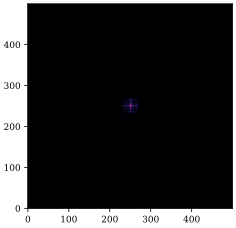

In [53]:
n=3
q_0 = 1j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

x = y = np.linspace(-0.004, 0.004, 500)
HG_nn = HGMode(q_0, n=n, m=n)
HG_nn_data = HG_nn.unm(x, y)**2
HG_nn_fft = np.fft.fft2(HG_nn_data)
HG_nn_shift = np.fft.fftshift(HG_nn_fft)
plt.imshow(np.abs(HG_nn_shift));

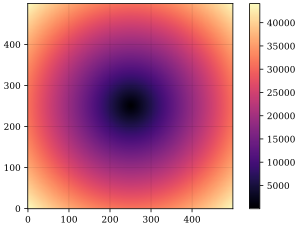

In [54]:
Factor_cs = []
x = y = np.linspace(-0.004, 0.004, 500)
freqsx = np.fft.fftshift(np.fft.fftfreq(HG_nn_data.shape[0], d=x[1]-x[0]))
freqsy = np.fft.fftshift(np.fft.fftfreq(HG_nn_data.shape[0], d=y[1]-y[0]))
freqsxx, freqsyy = np.meshgrid(freqsx, freqsy)
k = np.sqrt(freqsxx**2+freqsyy**2) + 0.00001
plt.imshow(k)
plt.colorbar();

In [3]:
Factor_cs = []
for n in range(20):
    HG_nn = HGMode(q_0, n=n, m=n)
    HG_nn_data = HG_nn.unm(x, y)**2
    HG_nn_fft = np.fft.fft2(HG_nn_data)
    HG_nn_shift = np.fft.fftshift(HG_nn_fft)
    data = HG_nn_shift**2/k*np.exp(-k**2*w0**2/4)
    Factor_cs.append(np.sum(data))

Factor_cs = np.array(Factor_cs)

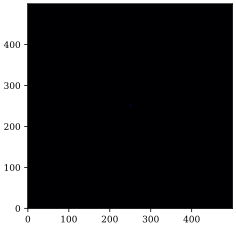

In [59]:
plt.imshow(abs(data))

[0.01645353 1.21090093]


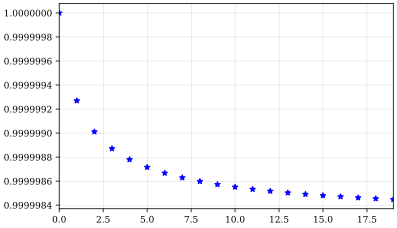

In [60]:
CTN_HOM = Factor_cs/Factor_cs[0]
print(popt)
plt.plot(CTN_HOM, "*");

In [7]:
q_0 = 0.1j
x = y = np.linspace(-0.004, 0.004, 600)
def radialProfile(n):
    HG_nn = HGMode(q_0, n=n, m=n)
    HG_nn_data = HG_nn.unm(x, y)**2

    yy, xx = np.indices((HG_nn_data.shape))
    center = (HG_nn_data.shape[0] - 1)/2
    r = np.sqrt((xx - center)**2 + (yy - center)**2)
    r = r.astype("int")
    
    freqs = np.fft.fftfreq(HG_nn_data.shape[0], d=x[1]-x[0])
    stepfreq = freqs[1] - freqs[0]
    freqAxis = np.unique(r)*stepfreq
    
    HG_nn_fourier = np.fft.fftshift(np.fft.fft2(HG_nn_data, norm='forward'))
    HG_nn_fourier = np.abs(HG_nn_fourier)**2
    
    tbin = np.bincount(r.ravel(), weights=HG_nn_fourier.ravel())*stepfreq
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr

    return freqAxis, radialprofile

In [4]:
freq00, FFT_HG00 = radialProfile(0)
freq11, FFT_HG11 = radialProfile(1)
freq22, FFT_HG22 = radialProfile(2)
freq33, FFT_HG33 = radialProfile(3)
freq44, FFT_HG44 = radialProfile(4)
freq55, FFT_HG55 = radialProfile(5)
freq66, FFT_HG66 = radialProfile(6)
freq77, FFT_HG77 = radialProfile(7)

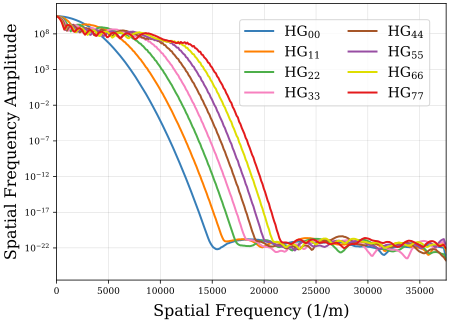

In [126]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.semilogy(freq00, FFT_HG00, label=r"$\mathrm{HG_{00}}$", lw=2., color=CB_color_cycle[0], alpha=1.)
ax.semilogy(freq11, FFT_HG11, label=r"$\mathrm{HG_{11}}$", lw=2., color=CB_color_cycle[1], alpha=1.)
ax.semilogy(freq22, FFT_HG22, label=r"$\mathrm{HG_{22}}$", lw=2., color=CB_color_cycle[2], alpha=1.)
ax.semilogy(freq33, FFT_HG33, label=r"$\mathrm{HG_{33}}$", lw=2., color=CB_color_cycle[3], alpha=1.)
ax.semilogy(freq44, FFT_HG44, label=r"$\mathrm{HG_{44}}$", lw=2., color=CB_color_cycle[4], alpha=1.)
ax.semilogy(freq55, FFT_HG55, label=r"$\mathrm{HG_{55}}$", lw=2., color=CB_color_cycle[5], alpha=1.)
ax.semilogy(freq66, FFT_HG66, label=r"$\mathrm{HG_{66}}$", lw=2., color=CB_color_cycle[8], alpha=1.)
ax.semilogy(freq77, FFT_HG77, label=r"$\mathrm{HG_{77}}$", lw=2., color=CB_color_cycle[7], alpha=1.)

ax.set_xlabel("Spatial Frequency (1/m)", fontsize=16, labelpad=8)
ax.set_ylabel("Spatial Frequency Amplitude", fontsize=16, labelpad=5)

freq_cutoff = 1/(x[1]-x[0])/2
ax.set_xlim([0, freq_cutoff+100])
plt.legend(fontsize=14, ncols=2, loc=(0.47, 0.63));

In [116]:
1/(x[1]-x[0])/2

31187.499999999927

In [5]:
q_0 = 2j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5

HG_nn_datas = []
x = y = np.linspace(-0.004, 0.004, 500)
xshifts = np.linspace(0, 1.2*x[-1], 200)
for n in range(8):
    HG_nn = HGMode(q_0, n=n, m=n)
    HG_nn_data = np.real(HG_nn.unm(x, y))
    temp = []
    for xshift in xshifts:
        HG_nn_shift_data = np.real(HG_nn.unm(x-xshift, y))

        overlap = np.sum(HG_nn_data*HG_nn_shift_data)
        temp.append(overlap)
    HG_nn_datas.append(temp)

HG_nn_datas = np.array(HG_nn_datas)

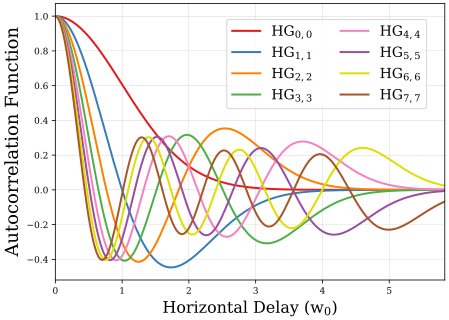

In [66]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(xshifts/w0, HG_nn_datas[0,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[7], label=r"$\mathrm{HG}_{0,0}$")
ax.plot(xshifts/w0, HG_nn_datas[1,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[0], label=r"$\mathrm{HG}_{1,1}$")
ax.plot(xshifts/w0, HG_nn_datas[2,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[1], label=r"$\mathrm{HG}_{2,2}$")
ax.plot(xshifts/w0, HG_nn_datas[3,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[2], label=r"$\mathrm{HG}_{3,3}$")
ax.plot(xshifts/w0, HG_nn_datas[4,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[3], label=r"$\mathrm{HG}_{4,4}$")
ax.plot(xshifts/w0, HG_nn_datas[5,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[5], label=r"$\mathrm{HG}_{5,5}$")
ax.plot(xshifts/w0, HG_nn_datas[6,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[8], label=r"$\mathrm{HG}_{6,6}$")
ax.plot(xshifts/w0, HG_nn_datas[7,:]/HG_nn_datas.max(), lw=2, color=CB_color_cycle[4], label=r"$\mathrm{HG}_{7,7}$")

ax.set_xlabel(r"Horizontal Delay ($\mathrm{w}_{0}$)", fontsize=16, labelpad=5)
ax.set_ylabel("Autocorrelation Function", fontsize=18, labelpad=5)
legend = plt.legend(fontsize=14, ncols=2, loc=(0.44, 0.62));

In [100]:
def Move_ax(ax, offset=0):
    box = ax.get_position()
    box.x0 = box.x0 + offset
    box.x1 = box.x1 + offset
    ax.set_position(box)
    return ax

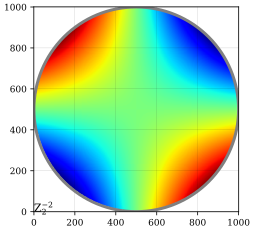

In [101]:
x = y = np.linspace(-1, 1, 1001)
xx, yy = np.meshgrid(x, y)
r = np.sqrt(xx**2+yy**2)
phi = np.arctan2(yy, xx)
index = r > 1
Z_nms = []
texts = []
for n in range(6):
    for m in np.arange(-n, n+1, 2):
        # print(n,m)
        Znm = Znm_eval(r, phi, n, m, 1)
        Znm[index] = np.nan
        Z_nms.append(Znm)
        if m < 0:
            text = rf"$\mathrm{{Z}}^{{-{abs(m)}}}_{{{n}}}$"
        else:
            text = rf"$\mathrm{{Z}}^{m}_{n}$"
        texts.append(text)
        
circle = plt.Circle((500, 500), 500, color='gray', linewidth=3, fill=False);
plt.imshow(Z_nms[3], cmap="jet")
plt.gca().add_patch(circle);
plt.gca().text(0, 0, texts[3]);

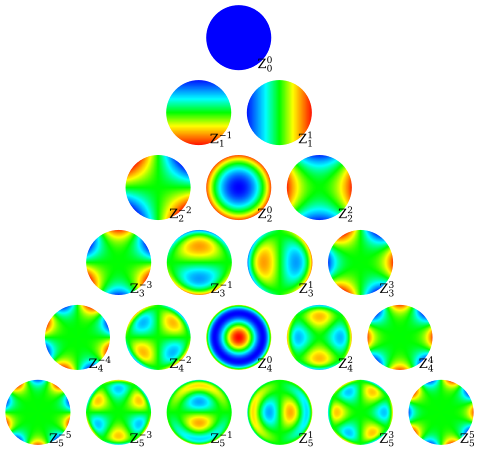

In [105]:
circles = [plt.Circle((500, 500), 500, color='white', linewidth=3, fill=False) for i in range(21)]

axd = plt.figure(figsize=(10,8)).subplot_mosaic(
    """
    ...A...
    .....BC
    ..DEF..
    ...GHIJ
    .KLMNO.
    .PQRSTU
    """
)
plt.subplots_adjust(hspace=0.1, wspace=0.1) 

offset = -0.28
axd["B"] = Move_ax(axd["B"], offset)
axd["C"] = Move_ax(axd["C"], offset)

offset = -0.167
axd["G"] = Move_ax(axd["G"], offset)
axd["H"] = Move_ax(axd["H"], offset)
axd["I"] = Move_ax(axd["I"], offset)
axd["J"] = Move_ax(axd["J"], offset)

offset = -0.055
axd["P"] = Move_ax(axd["P"], offset)
axd["Q"] = Move_ax(axd["Q"], offset)
axd["R"] = Move_ax(axd["R"], offset)
axd["S"] = Move_ax(axd["S"], offset)
axd["T"] = Move_ax(axd["T"], offset)
axd["U"] = Move_ax(axd["U"], offset)

# cmap_colors = [(0.0, CB_color_cycle[1]), (0.5, 'white'), (1.0, CB_color_cycle[0])]
# custom_cmap = LinearSegmentedColormap.from_list("BlueWhiteRed", cmap_colors)

colors = [
    (0.0, 'blue'),
    (0.3, 'cyan'),
    (0.5, 'lime'),
    (0.7, 'yellow'),
    (1.0, 'red')
]

custom_cmap = LinearSegmentedColormap.from_list("custom_jet", colors)

for index, (k, ax) in enumerate(axd.items()):
    ax.imshow(Z_nms[index], cmap=custom_cmap, )
    ax.add_patch(circles[index])
    ax.axis("off")
    color = "black" if index == 0 else "black"
    ax.text(1, 0., texts[index], transform=ax.transAxes, fontsize=13,
                verticalalignment='bottom', horizontalalignment='right',
                color=color, fontname="Courier")

# plt.gcf().savefig('./Zernikes_list.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

In [3]:
q_0 = 2j
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
x = y = np.linspace(-0.004, 0.004, 500)
lx = ly = 2*x[-1]/np.shape(x)[0]
def phaseHG33(wphase):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([-zero, 0, zero])*wphase/np.sqrt(2)
    y0 = np.array([-zero, 0, zero])*wphase/np.sqrt(2)
    
    phaseHG33 = np.ones((500, 500))

    for i in np.arange(500):
        for j in np.arange(500):
            x = (i-500/2)*lx
            y = (j-500/2)*ly
            
            if (x0[0] < x < x0[1] and -500*ly/2 < y < y0[0]) or (x0[2] < x < 500*lx/2 and -500*ly/2 < y < y0[0]) or \
            (-500*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < x0[2] and y0[0] < y < y0[1]) or \
            (x0[0] < x < x0[1] and y0[1] < y < y0[2]) or (x0[2] < x < 500*lx/2 and y0[1] < y < y0[2]) or \
            (-500*lx/2 < x < x0[0] and y0[2] < y < 500*ly/2) or (x0[1] < x < x0[2] and y0[2] < y < 500*ly/2):
                phaseHG33[i][j] = 0

    return np.rot90(phaseHG33)

def phaseHG11(wphase):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([0])*wphase/np.sqrt(2)
    y0 = np.array([0])*wphase/np.sqrt(2)
    
    phaseHG11 = np.ones((500, 500))

    for i in np.arange(500):
        for j in np.arange(500):
            x = (i-500/2)*lx
            y = (j-500/2)*ly
            
            if (x0[0] < x < 500*lx/2 and -500*ly/2 < y < y0[0]) or (-500*lx/2 < x < x0[0] and y0[0] < y < 500*ly/2):
                phaseHG11[i][j] = 0

    return np.rot90(phaseHG11)

def phaseHG22(wphase):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([-0.707106781186548, 0.707106781186548])*wphase/np.sqrt(2)
    y0 = np.array([-0.707106781186548, 0.707106781186548])*wphase/np.sqrt(2)
    
    phaseHG22 = np.ones((500, 500))

    for i in np.arange(500):
        for j in np.arange(500):
            x = (i-500/2)*lx
            y = (j-500/2)*ly
            
            if (x0[0] < x < x0[1] and -500*ly/2 < y < y0[0]) or \
            (-500*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < 500*lx/2 and y0[0] < y < y0[1]) \
            or (x0[0] < x < x0[1] and y0[1] < y < 500*ly/2):
                phaseHG22[i][j] = 0

    return np.rot90(phaseHG22)


def phaseHG44(wphase):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([-1.65068012388578, -0.524647623275290, 0.524647623275290, 1.65068012388578])*wphase/np.sqrt(2)
    y0 = np.array([-1.65068012388578, -0.524647623275290, 0.524647623275290, 1.65068012388578])*wphase/np.sqrt(2)
    
    phaseHG44 = np.ones((500, 500))

    for i in np.arange(500):
        for j in np.arange(500):
            x = (i-500/2)*lx
            y = (j-500/2)*ly
            
            if (x0[0] < x < x0[1] and -500*ly/2 < y < y0[0]) or (x0[2] < x < x0[3] and -500*ly/2 < y < y0[0]) or \
            (-500*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < x0[2] and y0[0] < y < y0[1]) or (x0[3] < x < 500*lx/2 and y0[0] < y < y0[1]) or \
            (x0[0] < x < x0[1] and y0[1] < y < y0[2]) or (x0[2] < x < x0[3] and y0[1] < y < y0[2]) or \
            (-500*lx/2 < x < x0[0] and y0[2] < y < y0[3]) or (x0[1] < x < x0[2] and y0[2] < y < y0[3]) or (x0[3] < x < 500*lx/2 and y0[2] < y < y0[3]) or \
            (x0[0] < x < x0[1] and y0[3] < y < 500*ly/2) or (x0[2] < x < x0[3] and y0[3] < y < 500*ly/2):
                phaseHG44[i][j] = 0

    return np.rot90(phaseHG44)

def phaseHG66(wphase):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([-2.35060497367449, -1.33584907401370, -0.436077411927617,
                   0.436077411927617, 1.33584907401370, 2.35060497367449])*wphase/np.sqrt(2)
    y0 = np.array([-2.35060497367449, -1.33584907401370, -0.436077411927617,
                   0.436077411927617, 1.33584907401370, 2.35060497367449])*wphase/np.sqrt(2)
    
    phaseHG66 = np.ones((500, 500))

    for i in np.arange(500):
        for j in np.arange(500):
            x = (i-500/2)*lx
            y = (j-500/2)*ly
            
            if (x0[0] < x < x0[1] and -500*ly/2 < y < y0[0]) or (x0[2] < x < x0[3] and -500*ly/2 < y < y0[0]) or (x0[4] < x < x0[5] and -500*ly/2 < y < y0[0]) or \
            (-500*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < x0[2] and y0[0] < y < y0[1]) or (x0[3] < x < x0[4] and y0[0] < y < y0[1]) or (x0[5] < x < 500*lx/2 and y0[0] < y < y0[1]) or \
            (x0[0] < x < x0[1] and y0[1] < y < y0[2]) or (x0[2] < x < x0[3] and y0[1] < y < y0[2]) or (x0[4] < x < x0[5] and y0[1] < y < y0[2]) or\
            (-500*lx/2 < x < x0[0] and y0[2] < y < y0[3]) or (x0[1] < x < x0[2] and y0[2] < y < y0[3]) or (x0[3] < x < x0[4] and y0[2] < y < y0[3]) or (x0[5] < x < 500*lx/2 and y0[2] < y < y0[3]) or\
            (x0[0] < x < x0[1] and y0[3] < y < y0[4]) or (x0[2] < x < x0[3] and y0[3] < y < y0[4]) or (x0[4] < x < x0[5] and y0[3] < y < y0[4]) or \
            (-500*lx/2 < x < x0[0] and y0[4] < y < y0[5]) or (x0[1] < x < x0[2] and y0[4] < y < y0[5]) or (x0[3] < x < x0[4] and y0[4] < y < y0[5]) or (x0[5] < x < 500*lx/2 and y0[4] < y < y0[5]) or\
            (x0[0] < x < x0[1] and y0[5] < y < 500*ly/2) or (x0[2] < x < x0[3] and y0[5] < y < 500*ly/2) or (x0[4] < x < x0[5] and y0[5] < y < 500*ly/2):
                phaseHG66[i][j] = 0

    return np.rot90(phaseHG66)


def phaseHG55(wphase):
    wphase *= w0
    zero1 = np.sqrt((5+np.sqrt(10))/2)
    zero2 = np.sqrt((5-np.sqrt(10))/2)

    x0 = np.array([-zero1, -zero2, 0, zero2, zero1])*wphase/np.sqrt(2)
    y0 = np.array([-zero1, -zero2, 0, zero2, zero1])*wphase/np.sqrt(2)
    
    phaseHG55 = np.ones((500, 500))

    for i in np.arange(500):
        for j in np.arange(500):
            x = (i-500/2)*lx
            y = (j-500/2)*ly
            
            if (x0[0] < x < x0[1] and -500*ly/2 < y < y0[0]) or (x0[2] < x < x0[3] and -500*ly/2 < y < y0[0]) or \
            (x0[4] < x < 500*lx/2 and -500*ly/2 < y < y0[0]) or \
            (-500*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < x0[2] and y0[0] < y < y0[1]) or \
            (x0[3] < x < x0[4] and y0[0] < y < y0[1]) or \
            (x0[0] < x < x0[1] and y0[1] < y < y0[2]) or (x0[2] < x < x0[3] and y0[1] < y < y0[2]) or \
            (x0[4] < x < 500*lx/2 and y0[1] < y < y0[2]) or \
            (-500*lx/2 < x < x0[0] and y0[2] < y < y0[3]) or (x0[1] < x < x0[2] and y0[2] < y < y0[3]) or \
            (x0[3] < x < x0[4] and y0[2] < y < y0[3]) or \
            (x0[0] < x < x0[1] and y0[3] < y < y0[4]) or (x0[2] < x < x0[3] and y0[3] < y < y0[4]) or \
            (x0[4] < x < 500*lx/2 and y0[3] < y < y0[4]) or \
             (-500*lx/2< x < x0[0] and y0[4] < y < 500*ly/2) or (x0[1] < x < x0[2] and y0[4] < y < 500*ly/2) or \
            (x0[3]< x < x0[4] and y0[4] < y < 500*ly/2):
                phaseHG55[i][j] = 0

    return np.rot90(phaseHG55)

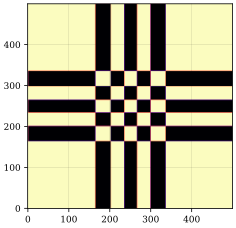

In [11]:
plt.imshow(phaseHG66(1));

In [6]:
q_0_basis = 0.4**2*q_0
step = x[1]-x[0]
eta_nms = []
indexes = []
for wphase in [0.4]:
    phase = phaseHG33(wphase)
    HG_00 = HGMode(q_0, n=0, m=0)
    HG_00_data = HG_00.unm(x, y)
    phase = phaseHG33(0.4)
    Field = HG_00_data*np.exp(1j*phase*np.pi)
    
    for n in range(12):
        temp = []
        temp_index = []
        for m in range(12):
            HG_nm = HGMode(q_0_basis, n=n, m=m)
            HG_nm_data = HG_nm.unm(x, y)
            rho_nm = np.sum(np.conj(HG_nm_data)*Field * step * step)
            eta_nm = np.abs(rho_nm*np.conj(rho_nm))
            temp.append(eta_nm)
            temp_index.append(f"HG{n}_{m}")
        eta_nms.append(temp)
        indexes.append(temp_index)

eta_nms = np.array(eta_nms)
indexes = np.array(indexes)

In [157]:
eta_nms_top = np.reshape(eta_nms, eta_nms.shape[0]**2)
indexes_top = np.reshape(indexes, indexes.shape[0]**2)
# ind = np.argpartition(eta_nms_top, -20)[-20:]
# top20 = eta_nms_top[ind]
# top20_indexes = indexes_top[ind]
# print(top20)
# print(top20_indexes)
ind = eta_nms_top > 0.1e-2
top01 = eta_nms_top[ind]
top01_indexes = indexes_top[ind]

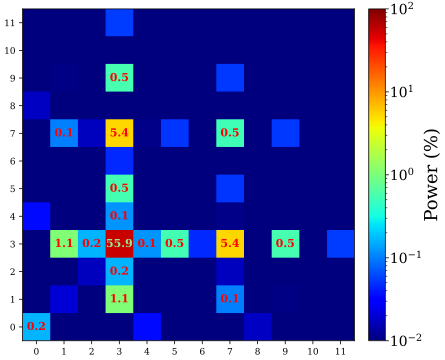

In [220]:
minn = eta_nms.min()
maxx = eta_nms.max()

fig, ax = plt.subplots(figsize=(7, 6))

im = ax.imshow(eta_nms*100, cmap="jet", norm=LogNorm(vmin=0.01, vmax=100),)

ax.set_xticks(np.arange(12))
ax.set_yticks(np.arange(12))

for index, top in enumerate(top01_indexes):
    n, m = top[2:].split("_")
    n = int(n)
    m = int(m)
    color = "lightgreen" if n == 3 and m == 3 else "r" 
    ax.text(n, m, f"{top01[index]*100:.1f}", fontsize=11, verticalalignment='center',
            horizontalalignment='center', color=color, fontweight="bold")

plt.grid(False)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
cbar = fig.colorbar(im, cax=cax, norm=mpl.colors.LogNorm(vmin=0, vmax=1))
cbar.set_label(label=r"Power (%)", fontsize=18, rotation=90, labelpad=1)
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=14, rotation=0, pad=1);

In [7]:
step = x[1]-x[0]
HG_00 = HGMode(q_0, n=0, m=0)
HG_00_data = HG_00.unm(x, y)

eta_nns = []
wphase_s = np.linspace(0.2, 0.8, 100)
# wphase_s = np.linspace(0.37, 0.43, 40) # get maximum efficiency for HG33
for wphase in wphase_s:
    q_0_basis = wphase**2*q_0
    temp = []
    for n in range(1,7):
    # for n in [3]:
        phase = eval(f"phaseHG{n}{n}")(wphase)
        Field = HG_00_data*np.exp(1j*phase*np.pi)
        HG_nn = HGMode(q_0_basis, n=n, m=n)
        HG_nn_data = HG_nn.unm(x, y)
        rho_nn = np.sum(np.conj(HG_nn_data)*Field * step * step)
        eta_nn = np.abs(rho_nn*np.conj(rho_nn))
    
        temp.append(eta_nn)
    eta_nns.append(temp)

eta_nns = np.array(eta_nns)
np.save('./Save/eta_nns.npy', eta_nns)

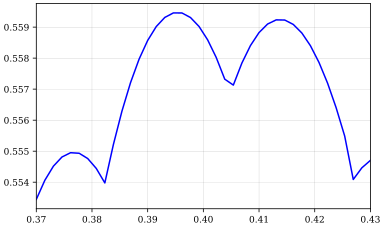

In [9]:
plt.plot(wphase_s, eta_nns);

0.5594123758459991


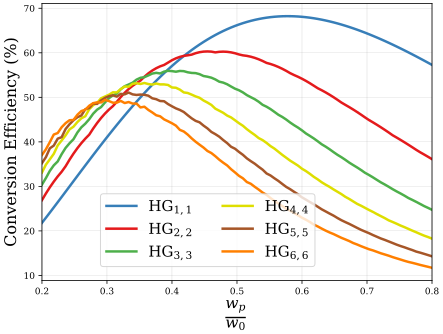

In [25]:
eta_nns = np.load('./Save/eta_nns.npy')
wphase_s = np.linspace(0.2, 0.8, 100)

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(wphase_s, eta_nns[:,0]*100, lw=2.5, color=CB_color_cycle[0], label=r"$\mathrm{HG}_{1,1}$")
ax.plot(wphase_s, eta_nns[:,1]*100, lw=2.5, color=CB_color_cycle[7], label=r"$\mathrm{HG}_{2,2}$")
ax.plot(wphase_s, eta_nns[:,2]*100, lw=2.5, color=CB_color_cycle[2], label=r"$\mathrm{HG}_{3,3}$")
ax.plot(wphase_s, eta_nns[:,3]*100, lw=2.5, color=CB_color_cycle[8], label=r"$\mathrm{HG}_{4,4}$")
ax.plot(wphase_s, eta_nns[:,4]*100, lw=2.5, color=CB_color_cycle[4], label=r"$\mathrm{HG}_{5,5}$")
ax.plot(wphase_s, eta_nns[:,5]*100, lw=2.5, color=CB_color_cycle[1], label=r"$\mathrm{HG}_{6,6}$")

legend = plt.legend(fontsize=15, ncols=2, loc=(0.15, 0.05))

ax.set_xlabel(r"$\frac{w_{p}}{w_{0}}$", fontsize=22)
ax.set_ylabel("Conversion Efficiency (%)", fontsize=16);
print(eta_nns[:,2].max())

In [26]:
eta_nns[:,5].max()

0.4940901578851884

In [23]:
HG33_phase_map = phaseHG33(1)

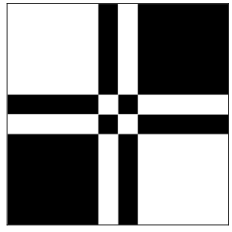

In [24]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.imshow(HG33_phase_map, cmap="gray")
plt.grid(False)
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([]);
# ax.set_axis_off()

fig.savefig('./HG33map.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

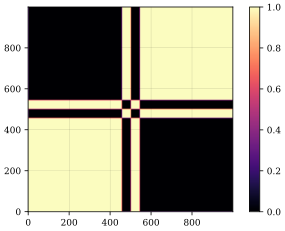

In [15]:
k = 2*np.pi/(1064e-9)
w0 = 1e-3
q_old_c = 1j*np.pi*w0**2/(1064e-9)
q_new_c = 1j*np.pi*(w0*0.4)**2/(1064e-9)
npts = 1000

x = y = np.linspace(-1, 1, npts)*4*w0
lx = ly = 2*x[-1]/np.shape(x)[0]


def phaseHG33(wphase, w0):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([-zero, 0, zero])*wphase/np.sqrt(2)
    y0 = np.array([-zero, 0, zero])*wphase/np.sqrt(2)
    
    phaseHG33 = np.ones((npts, npts))

    for i in np.arange(npts):
        for j in np.arange(npts):
            x = (i-npts/2)*lx
            y = (j-npts/2)*ly
            
            if (x0[0] < x < x0[1] and -npts*ly/2 < y < y0[0]) or (x0[2] < x < npts*lx/2 and -npts*ly/2 < y < y0[0]) or \
            (-npts*lx/2 < x < x0[0] and y0[0] < y < y0[1]) or (x0[1] < x < x0[2] and y0[0] < y < y0[1]) or \
            (x0[0] < x < x0[1] and y0[1] < y < y0[2]) or (x0[2] < x < npts*lx/2 and y0[1] < y < y0[2]) or \
            (-npts*lx/2 < x < x0[0] and y0[2] < y < npts*ly/2) or (x0[1] < x < x0[2] and y0[2] < y < npts*ly/2):
                phaseHG33[i][j] = 0

    return phaseHG33

def ampHG33(wphase, w0, grid=2):
    wphase *= w0
    zero = np.sqrt(1.5)
    x0 = np.array([-zero, 0, zero])*wphase/np.sqrt(2)
    y0 = np.array([-zero, 0, zero])*wphase/np.sqrt(2)
    
    ampHG33 = np.ones((npts, npts))
    for x in x0:
        ix = int(x/lx + npts/2)
        ampHG33[ix:ix+grid] = 0
    for y in y0:
        iy = int(y/ly + npts/2)
        ampHG33[:, iy:iy+grid] = 0

    return ampHG33

HG33_phase_map = phaseHG33(0.4, w0)
plt.imshow(HG33_phase_map)
plt.colorbar();

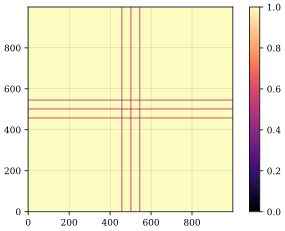

In [16]:
HG33_amp_map = ampHG33(0.4, w0)
plt.imshow(HG33_amp_map)
plt.colorbar();

In [17]:
maxtem = 20
q_old = BeamParam(q=q_old_c)
q_new = BeamParam(q=q_new_c)

HG33_amp_map = ampHG33(0.23, w0, grid=1)
# HG33_amp_map = ampHG33(0.24, w0, grid=0)

Z = HG33_amp_map*np.exp(
    1j * np.pi * HG33_phase_map
)

qx1, qy1, qx2, qy2 = q_old, q_old, q_new, q_new
K = map_scattering_coefficients((qx1, qy1, qx2, qy2), maxtem, x, y, Z)

couplings = []
for n in range(10):
    for m in range(10):
        couplings.append(abs(K[0, n, 0, m])**2)
        if n==3 and m==3:
            print(f"### HG00 -> {n}{m}: ###", abs(K[0, n, 0, m])**2)
        # else:
            # print(f"HG00 -> {n}{m}:", abs(K[0, n, 0, m])**2)

summ = sum(couplings)
abs(K[0, 3, 0, 3])**2/summ

### HG00 -> 33: ### 0.5323501671366792


0.7861856741495586

(5.3444309853959675+0j)
-14204.37608251802
(8.755579971449821e-33+0j)
(5.01005610243347+1.8222315871406087j)
-13992.506592768883
(9.434731456962967e-33-1.5544825213365023e-32j)


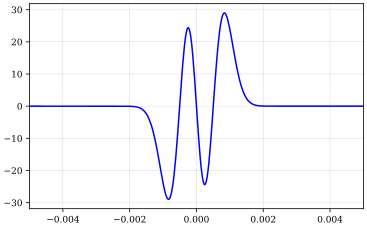

In [19]:
q_0 = 1j 
lambd = 1064e-9
zR = np.imag(q_0)
w0 = (zR*lambd/np.pi)**0.5
    
x = y = np.linspace(-1, 1, 400)*0.005
deltax = x[1] - x[0]

HG33 = HGMode(q_0, n=3, m=3)
HG33_data_x = HG33.un(x)

q_prime = q_0 + zR*1e-1
HG33_prime = HGMode(q_prime, n=3, m=3)
HG33_data_prime_x = HG33_prime.un(x)

plt.plot(x, np.real(HG33_data_x));

In [10]:
deltazs = np.linspace(-1, 1, 50)*zR*1e-1
gammas = -2*deltazs/zR
delta_gamma = gammas[1]-gammas[0]

overlaps = []
for deltaz in deltazs:
    q_prime = q_0 + deltaz
    
    HG33_prime = HGMode(q_prime, n=3, m=3)
    HG33_data_prime_x = HG33_prime.un(x)
    overlap = np.sum(HG33_data_prime_x*np.conj(HG33_data_x))*deltax

    overlaps.append(overlap)

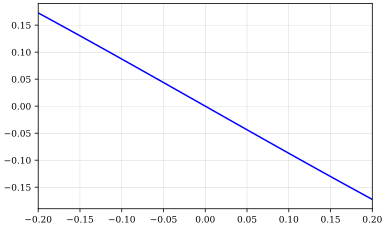

In [21]:
plt.plot(gammas, np.imag(overlaps));

(-0.8749948751976282, -0.875)

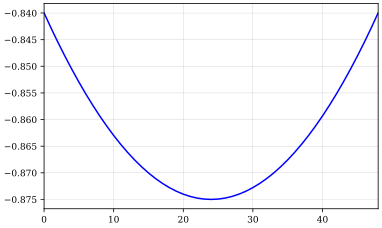

In [22]:
slopes = np.diff(np.imag(overlaps))/delta_gamma
plt.plot(slopes);
slopes.min(), -(2*3+1)/8